<a href="https://colab.research.google.com/github/Zeegeuze/personal-exercises/blob/main/Preparation_presentation_bootcamp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation bootcamp project presentation
I'll need to present a project in my bootcamp*, which needs to be presented to the teacher before. This will be the both the preparation for the teacher as well as the preparation for the presentation.

*I'm following a bootcamp 'Data Science and AI' at Le Wagon in Brussels from January 15th to March 15th.

## Introduction

### Code

In [ ]:
# Install yt-dlp and download video from Youtube
!pip install -U --pre yt-dlp
!yt-dlp -o "short_geoguessr.%(ext)s" https://www.youtube.com/shorts/cCVJtd0ZPHQ

In [2]:
# Display video in Notebook

from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/short_geoguessr.webm','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
video = HTML("""
<CENTER>
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
</CENTER>
""" % data_url)



### Video

Do you know GeoGuessr? It's an onlime game where participant are given a random pictures, after which they need to guess the location as good as possible. The pro's are able to guess in a fraction of a second where the picture is from. Below is a small exerpt from one of those pros:

In [3]:
video

If a human can do this, we need to be able to beat this via deep learning, isn't it? We're going to use the following [dataset](https://www.kaggle.com/datasets/ubitquitin/geolocation-geoguessr-images-50k/data) from Kaggle and give it a go.

The dataset consists of 50k pictures of around 150 countries, divided in maps.

They are very unevenly spread, as we will see later, so I might drop some or focus on certain areas, definitely to start with.

Later on, we'll use a pre-trained dataset of TensorFlow to make our model even better.

## Set-up

In [4]:
# Connect and check CPU
# check https://developer.nvidia.com/cuda-gpus#compute -> Cuda-enabled Datacenter Products
# Score of GPU should be 7.0+
# Should be a minimum of Tesla T4 for optimal results -> otherwise 'factory reset runtime'

# !nvidia-smi -L

# Tesla T4 seems to be standard, so I'll comment this for now.

In [5]:
# Get some helper functions for quicker results
# Those are some functions I found / created / updated
# -> commented as eventually not used

# !wget https://raw.githubusercontent.com/Zeegeuze/data_science_general/main/helper_functions.py
# from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Download and upload the dataset from Kaggle
Most of this will be commented, as this only needs to be done once,
because the data will be saved on my Google Drive.

In [6]:
# 1. Get API from Kaggle and safe the .json file here

# Setup Kaggle permissions: works only with GPU, so start that first

# ! pip install kaggle --quiet
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# 2. Download the dataset .zip file: as this is done, I'll comment the code.
# !kaggle datasets download  ubitquitin/geolocation-geoguessr-images-50k

In [ ]:
# 3. Mount Google Drive -> this will need to be done every time to have access to the data

from google.colab import drive

drive.mount('/content/drive')

In [9]:
# 4. Unzip the file into the correct path within Google Drive

# Do this AFTER mounting the drive, to be sure it's visible.
# Take take that you add the correct name: 'ubitquitin' needed to be deleted here
# -n is added not to overwrite existing files
# I needed to run this cell some time in order to get all the pics downloaded as it only downloaded a part

# ! unzip -n /content/drive/MyDrive/sets-kaggle/geolocation/geolocation-geoguessr-images-50k.zip -d drive/MyDrive/sets-kaggle/geolocation

## Get to know the data

### Check distribution and classes

In [10]:
import os

**Get all the classes**

In [24]:
countries = os.listdir("/content/drive/MyDrive/sets-kaggle/geolocation/compressed_dataset")
len(countries)

124

There are not 150 but only 124 countries / classes

In [13]:
# Check the pictures

import pandas as pd

countries = []
images = []
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/sets-kaggle/geolocation/compressed_dataset"):
  countries.append(dirpath.split("/")[-1])
  images.append(len(filenames))
  # country = dirpath.split("/")[-1]
  # print(f"There are {len(dirnames)} directories and {len(filenames)} images in {country}.")

length_countries = pd.DataFrame({"countries": countries, "images": images})

In [23]:
length_countries.head()

countries  images
0  compressed_dataset       0
1               Aland       9
2             Albania      41
3      American Samoa      16
4             Andorra      13

### graphs
1. Pictures per country

We can clearly see how unevenly there are distributed


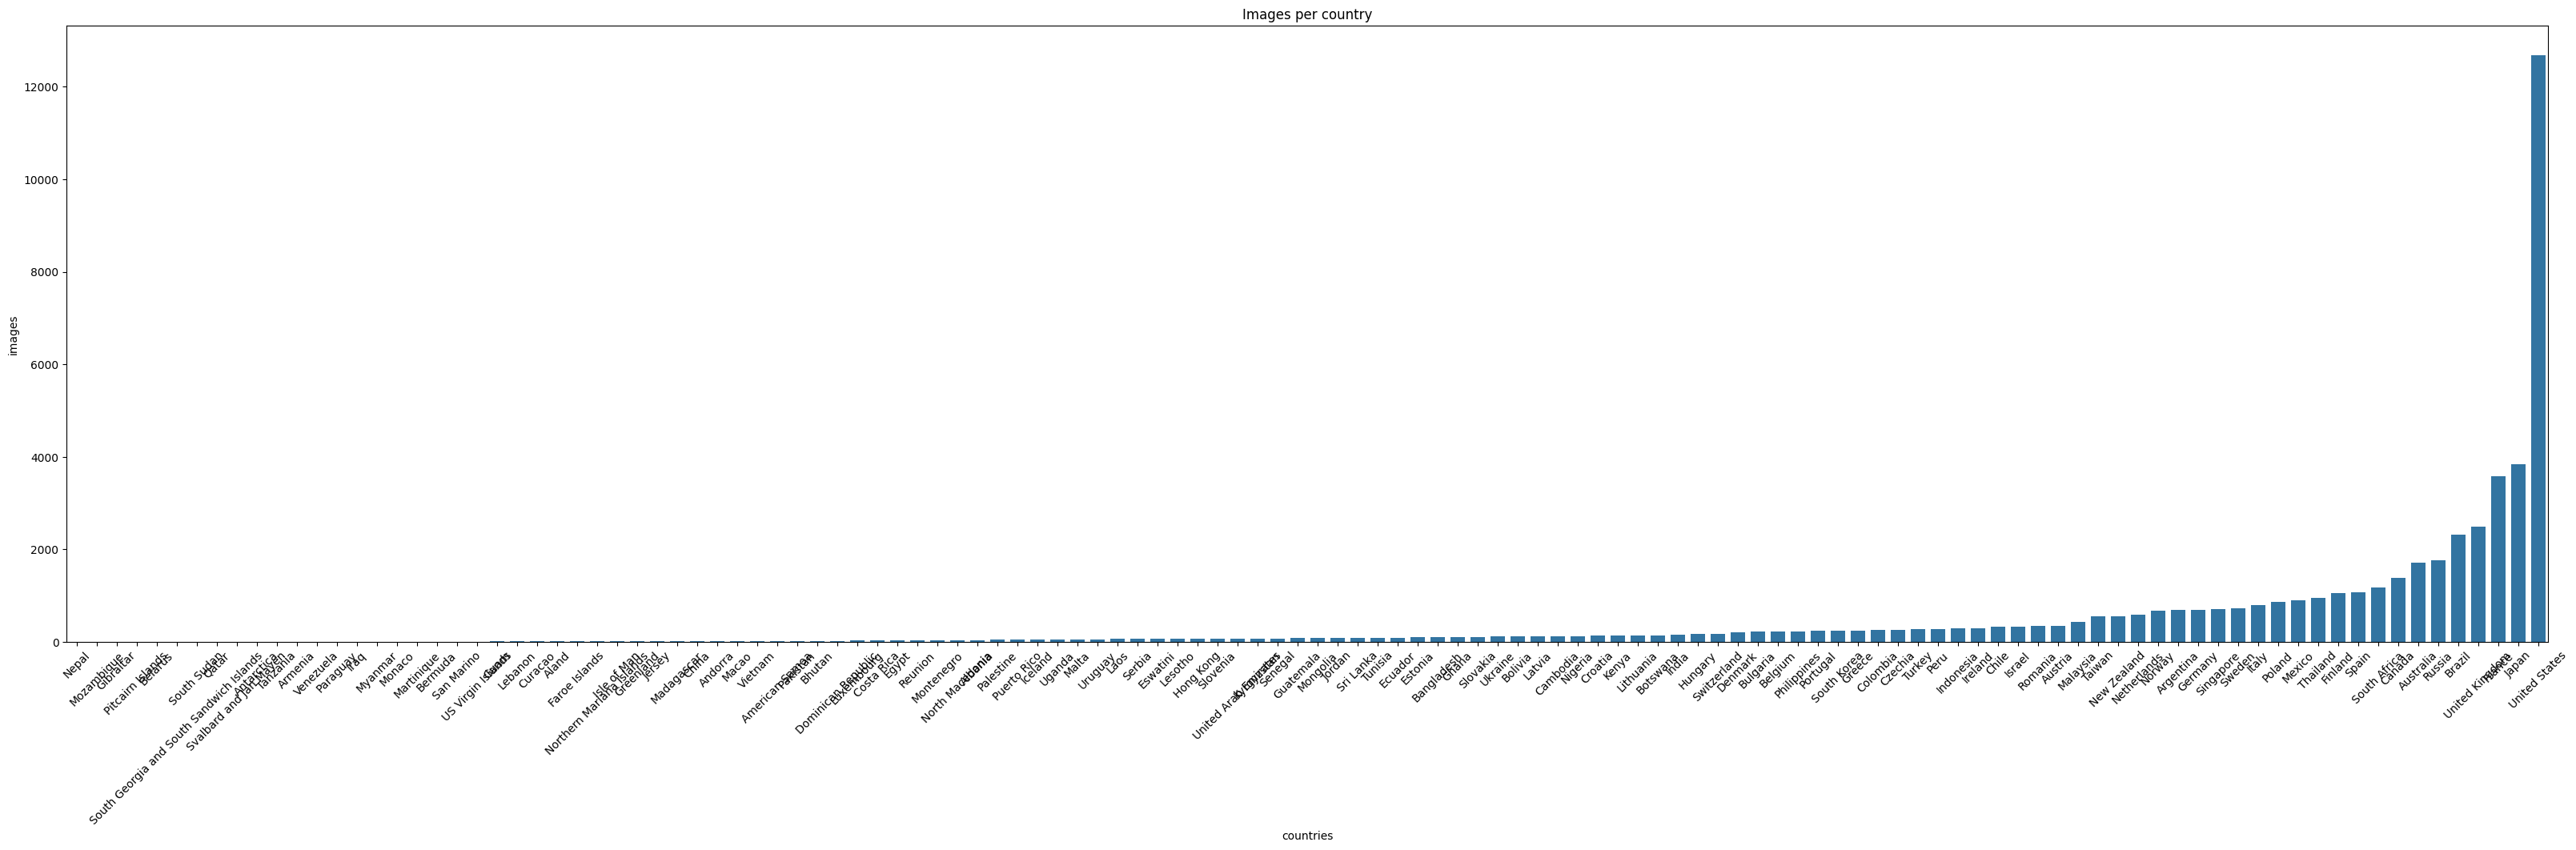

In [15]:
# Checking for images per country to see if they are evenly distributed

import seaborn as sns
sorted_df = length_countries[1:].sort_values('images').copy()

plt1 = sns.barplot(x = sorted_df['countries'], y = sorted_df['images'], gap=0.1)
plt1.figure.set_size_inches(40,10)
plt1.tick_params(axis='x', rotation=45)
plt1.set(title="Images per country");

In [16]:
# Let's check them acumulated

sorted_pictures = sorted_df[1:].sort_values('images').copy()
sorted_pictures['cum_sort_images'] = sorted_pictures.images.cumsum()

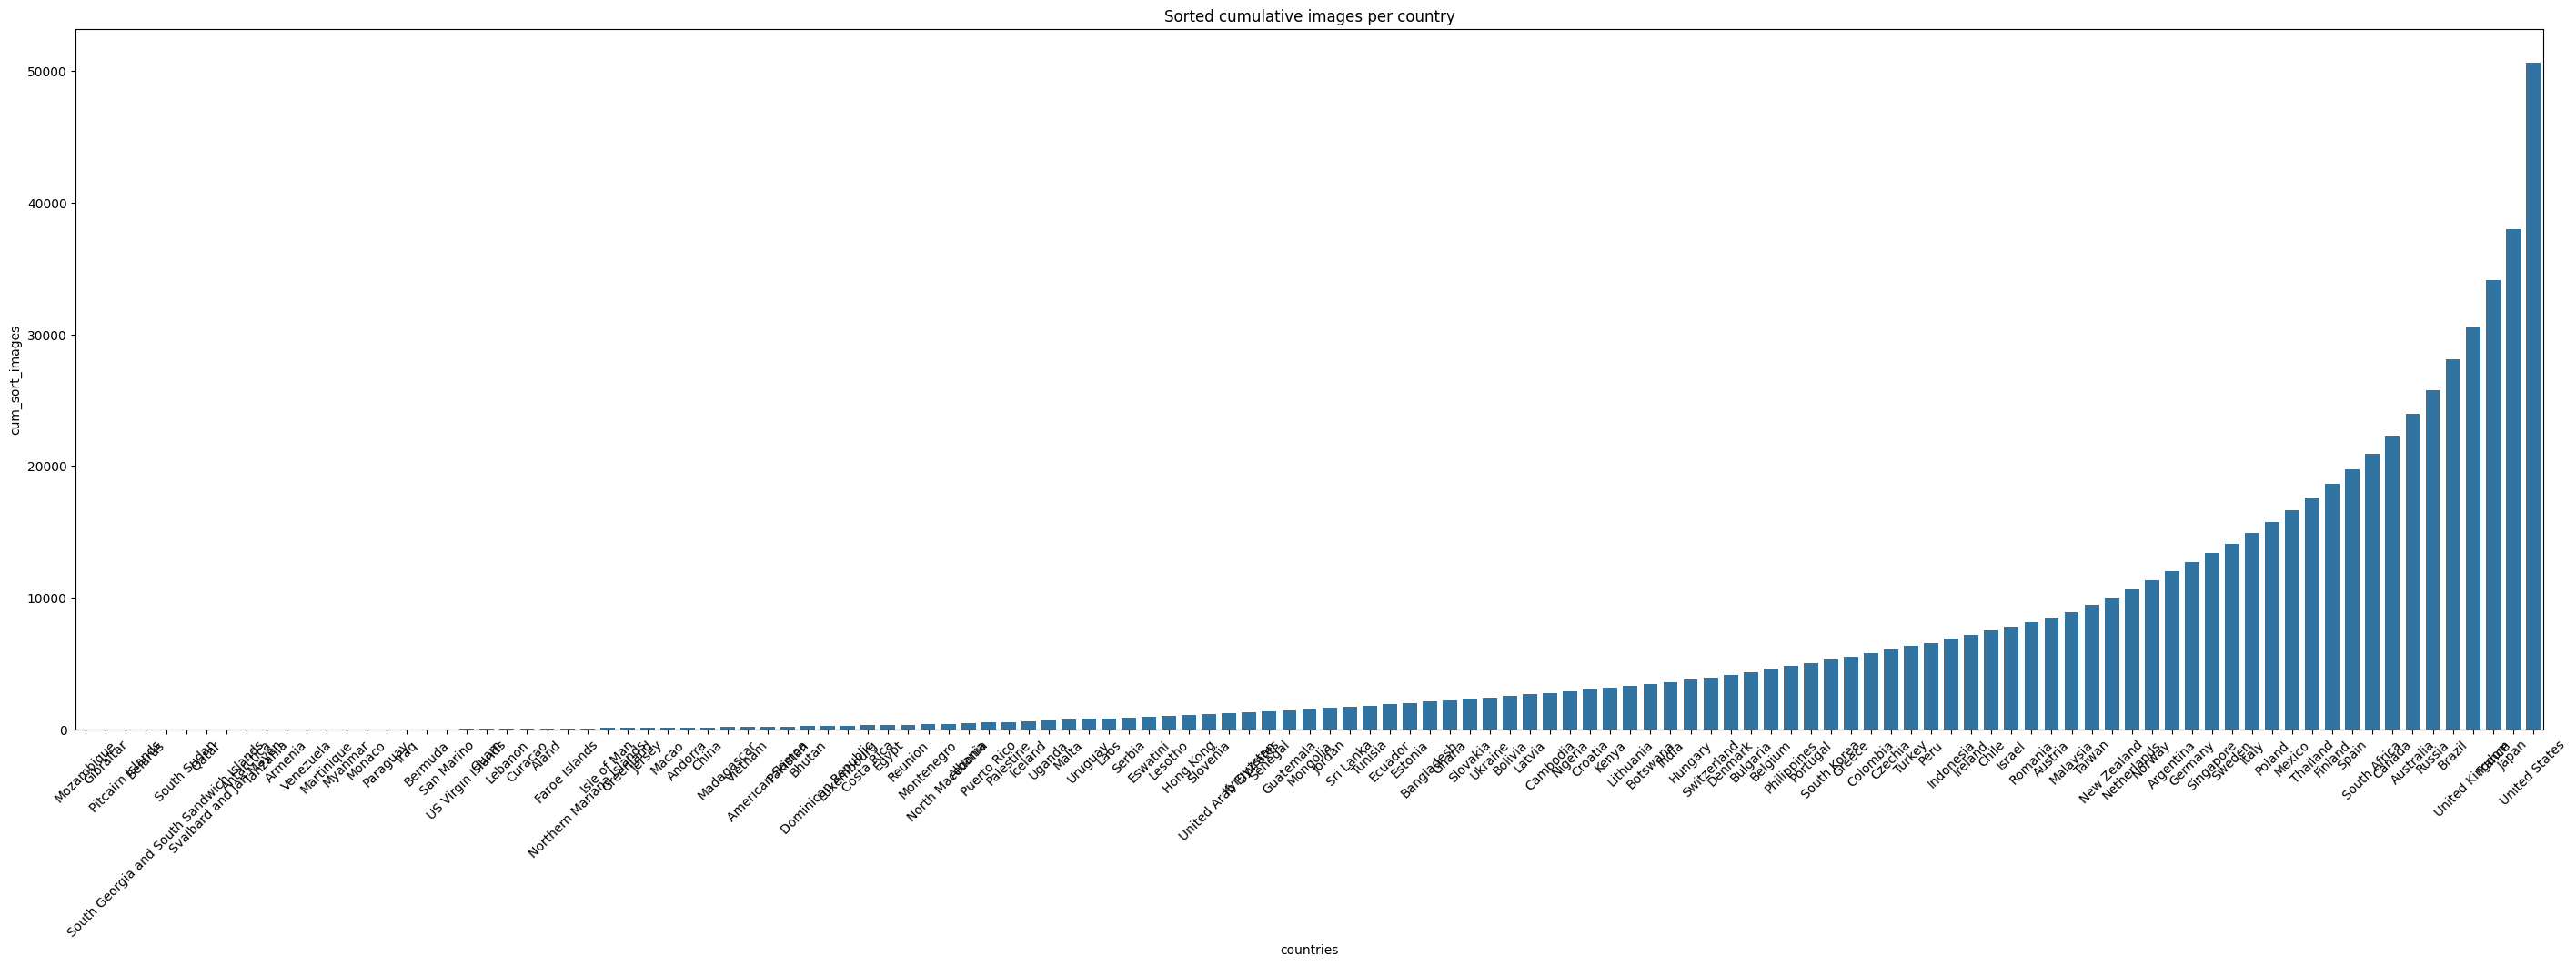

In [17]:
plt2 = sns.barplot(x = sorted_pictures['countries'], y = sorted_pictures['cum_sort_images'], gap=0.1)
plt2.figure.set_size_inches(35,10)
plt2.tick_params(axis='x', rotation=45)
plt2.set(title="Sorted cumulative images per country");

2. Distribution of amount of pictures

If we put the amount of pictures per class the unevenly distribution is even clearer.

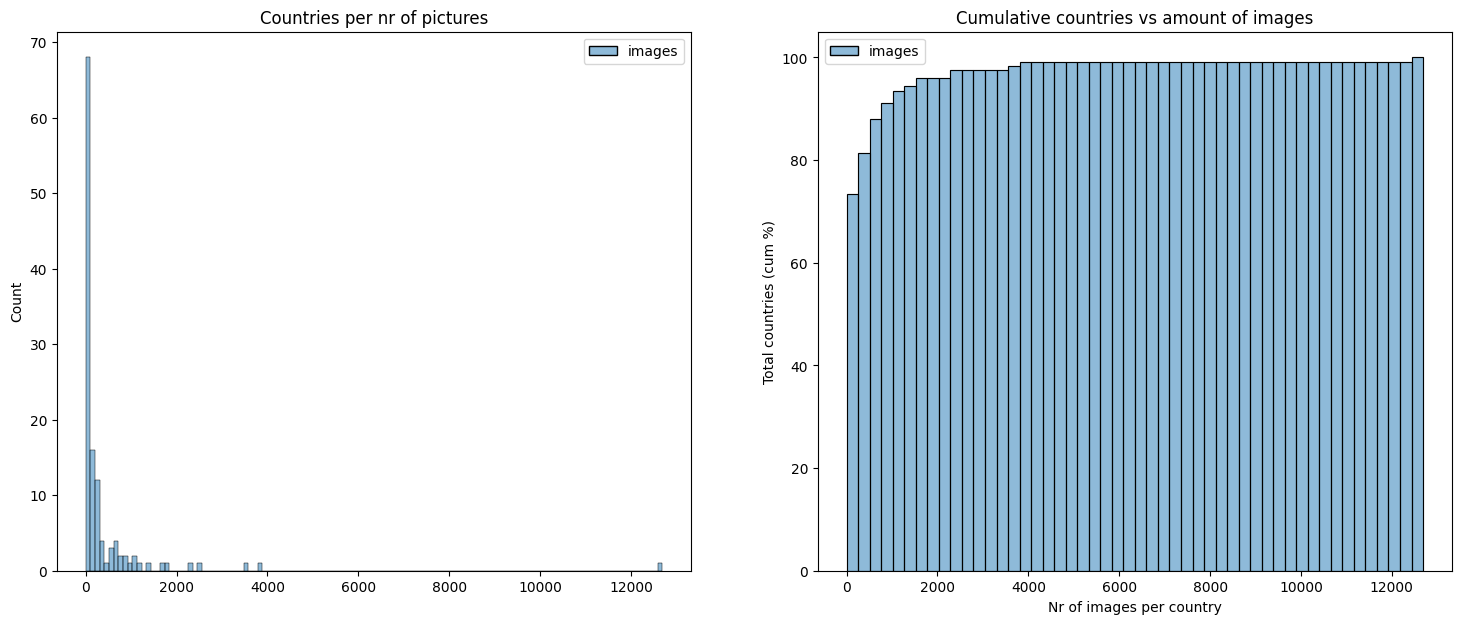

In [18]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

ax1 = plt.subplot(1,2,1)
ax1 = sns.histplot(sorted_df).set(title="Countries per nr of pictures")

ax2 = plt.subplot(1,2,2)
ax2 = sns.histplot(sorted_df, cumulative=True, bins=50, stat="percent").set(title="Cumulative countries vs amount of images",
                                                             xlabel="Nr of images per country",
                                                             ylabel="Total countries (cum %)");

In [19]:
# How many countries do we have with over 100 images? Even though a treshold of 1000 would be better we won't have enough countries that way.
# What about 1000?

countries_over_100 = sorted_df[sorted_df['images'] > 100].count()
countries_over_1000 = sorted_df[sorted_df['images'] > 1000].count()

over_100 = countries_over_100['countries']
over_1000 = countries_over_1000['countries']
image_over_100 = sorted_df[sorted_df['images'] > 100]['images'].sum()
image_over_1000 = sorted_df[sorted_df['images'] > 1000]['images'].sum()

perc_100 = round(over_100 / len(sorted_df) * 100, 1)
perc_1000 = round(over_1000 / len(sorted_df) * 100, 1)
perc_100_images = round(image_over_100 / sorted_df['images'].sum() * 100, 1)
perc_1000_images = round(image_over_1000 / sorted_df['images'].sum() * 100, 1)

In [20]:
print(f"""Total countries with more then 100 pictures: {over_100} ({perc_100}%) \n
Total countries with more then 1000 pictures: {over_1000} ({perc_1000}%) \n
Sum of all pictures of countries with more then 100 images: {image_over_100} ({perc_100_images}%) \n
Sum of all pictures of countries with more then 1000 images: {image_over_1000} ({perc_1000_images}%)""")

Total countries with more then 100 pictures: 56 (45.2%) 

Total countries with more then 1000 pictures: 11 (8.9%) 

Sum of all pictures of countries with more then 100 images: 48664 (96.0%) 

Sum of all pictures of countries with more then 1000 images: 33058 (65.2%)


## General conclusion

**Conclusion 2**
* It is very clear that the data is unevenly distributed. There are **50.000** pictures, of which 6388 images (12,78%) belong to 75% of the countries.

* If we dive further, we see that only 56 countries (45%) have more than a 100 pictures, which is the absolute bare minimum for deep learning
* Just 11 countries more then a 1000 pictures (8,9%)

It is very unlikely to get proper results with this dataset. We'll need to decide if we will:
*  drop the project altogether
* work with the smaller dataset (which still has 48.000 pictures over those 56 countries).

  If we choose to work with his dataset the proposal would be to drop 2/3 (8000) images from the US data, bringing it in line with the other countries. The total data would become 40.000 pictures for 56 countries.

If we would decide to go on with the project, additional data might get obtained later, as the pictures are just print screens of Google Maps.

In [21]:
short_df = sorted_df[sorted_df['images'] > 100]

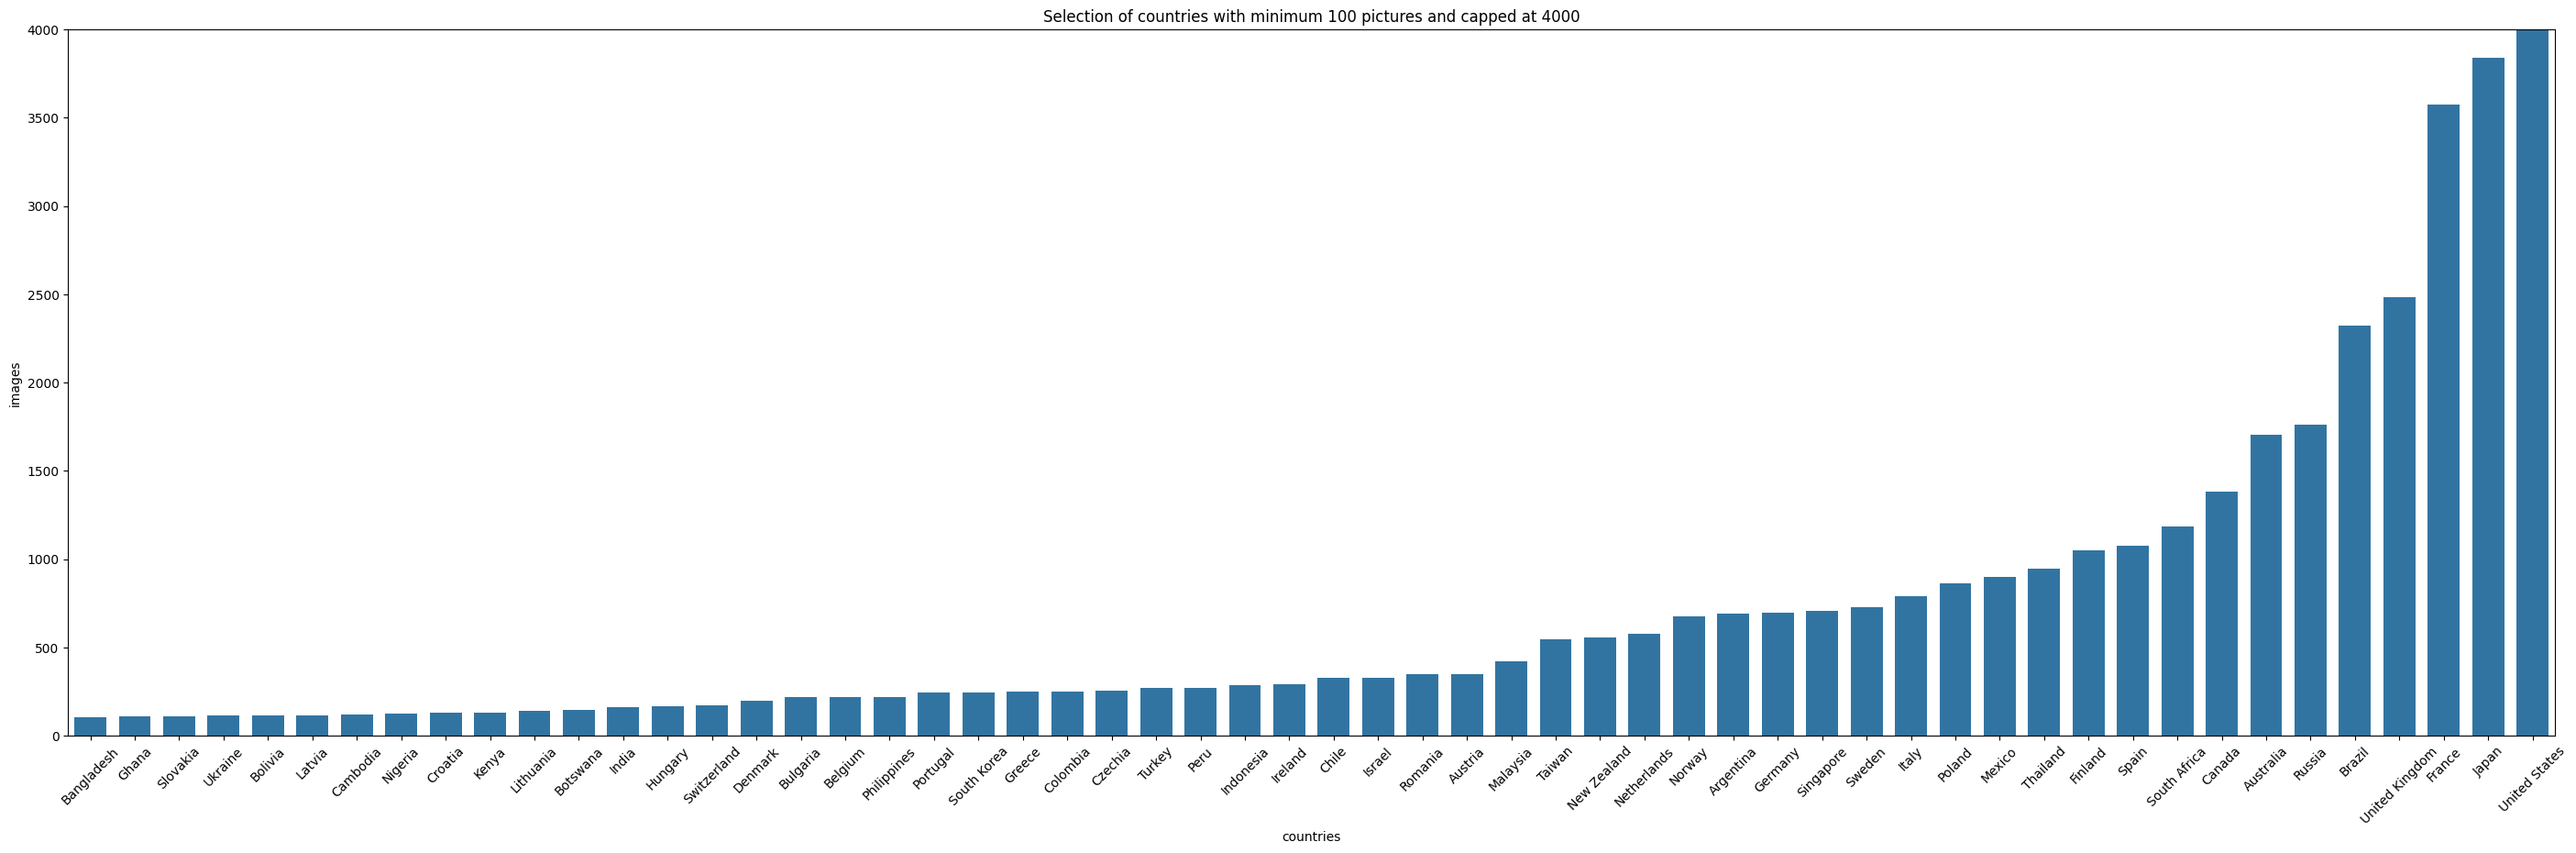

In [22]:
plt3 = sns.barplot(x = short_df['countries'], y = short_df['images'], gap=0.1)
plt3.figure.set_size_inches(35,10)
plt3.tick_params(axis='x', rotation=45)
plt3.set_ylim(0, 4000)
plt3.set(title="Selection of countries with minimum 100 pictures and capped at 4000");